<a href="https://colab.research.google.com/github/kiran-bhandari16/LSTM-Stock-Price-Prediciton/blob/main/Economic_Political_NewsSentiment_Analysis_with_Polarity_and_Subjectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import warnings
warnings.filterwarnings('ignore')


from textblob import TextBlob

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_roc_curve

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving economical.csv to economical.csv
Saving political.csv to political.csv
Saving sbl_price.csv to sbl_price.csv


In [ ]:
economic_df=pd.read_csv("economical.csv")
economic_df.head()

Date                                       economictext
0  2016-04-25  ['PAC directs NEA to stop work of Lower Solu u...
1   2016-05-4  ['Kate Upton announces engagement to Justin Ve...
2   2016-06-5  ['Govt, CAAN seal deal on construction of int’...
3  2016-06-10  ['CIAA hurdle could prove costly: NT official'...
4  2016-06-11  ['Pokhara is cheapest tourism destination: For...

In [ ]:
economic_df.shape

(2143, 2)

In [ ]:
economic_df.set_index("Date", inplace=True)
economic_df

economictext
Date                                                         
2016-04-25  ['PAC directs NEA to stop work of Lower Solu u...
2016-05-4   ['Kate Upton announces engagement to Justin Ve...
2016-06-5   ['Govt, CAAN seal deal on construction of int’...
2016-06-10  ['CIAA hurdle could prove costly: NT official'...
2016-06-11  ['Pokhara is cheapest tourism destination: For...
...                                                       ...
2022-06-25  ['Pokhara Metropolitan City brings new budget ...
2022-06-26  ['17 cooperatives put in blacklist on charge o...
2022-06-27  ['Nepal received FDI commitments of Rs 51.56 b...
2022-06-28  ['Stockbrokers permitted to operate their own ...
2022-06-29  ['EPF taking Oriental Cooperative Chairman Bas...

[2143 rows x 1 columns]

In [ ]:
political_df=pd.read_csv("political.csv")
political_df.head()

Date                                      politicaltext
0  2016-04-25  ['NHRC: Govt quake response too slow, NGOs non...
1   2016-06-5  ['Govt distributed budget on its own will: Deu...
2   2016-06-6  ['7 appellate courts to become high courts', '...
3   2016-06-7           ['PM Oli calls for national unity govt']
4   2016-06-9   ["Neupane elected RPP Nepal's Makawanpur Chair"]

In [ ]:
political_df.shape

(2170, 2)

In [ ]:
political_df.set_index("Date", inplace=True)
political_df

politicaltext
Date                                                         
2016-04-25  ['NHRC: Govt quake response too slow, NGOs non...
2016-06-5   ['Govt distributed budget on its own will: Deu...
2016-06-6   ['7 appellate courts to become high courts', '...
2016-06-7            ['PM Oli calls for national unity govt']
2016-06-9    ["Neupane elected RPP Nepal's Makawanpur Chair"]
...                                                       ...
2022-06-25  ["Khadka appointed chief of NC's central polic...
2022-06-26  ['National Assembly meeting being held today',...
2022-06-27  ['Newly-appointed ministers to be sworn in tod...
2022-06-28  ['Govt committed to development, good governan...
2022-06-29  ['Bamdev Gautam forms a new political party na...

[2170 rows x 1 columns]

In [ ]:
stock_df=pd.read_csv("sbl_price.csv")
stock_df.head()

S.N.        Date    Open    High     Low     Ltp  % Change        Qty  \
0     1  2022-06-29  318.90  318.90  310.00  315.00      0.64  19,455.00   
1     2  2022-06-28  312.00  316.50  306.00  313.00      0.32  18,396.00   
2     3  2022-06-27  322.00  325.00  310.00  312.00     -2.50  35,290.00   
3     4  2022-06-26  312.90  320.00  308.00  320.00      4.23  90,805.00   
4     5  2022-06-24  305.00  310.00  298.20  307.00     -0.97  83,733.00   

        Turnover  
0   6,127,716.20  
1   5,707,986.70  
2  11,125,995.50  
3  28,577,745.10  
4  25,399,389.80

In [ ]:
stock_df.shape

(2000, 9)

In [ ]:
stock_df=stock_df[['Date','Open','High','Low','Ltp','Qty','Turnover']]
stock_df

Date    Open    High     Low     Ltp        Qty       Turnover
0     2022-06-29  318.90  318.90  310.00  315.00  19,455.00   6,127,716.20
1     2022-06-28  312.00  316.50  306.00  313.00  18,396.00   5,707,986.70
2     2022-06-27  322.00  325.00  310.00  312.00  35,290.00  11,125,995.50
3     2022-06-26  312.90  320.00  308.00  320.00  90,805.00  28,577,745.10
4     2022-06-24  305.00  310.00  298.20  307.00  83,733.00  25,399,389.80
...          ...     ...     ...     ...     ...        ...            ...
1995  2013-03-21  306.00  311.00  303.00  308.00   2,682.00     821,123.00
1996  2013-03-20  312.00  312.00  306.00  306.00     849.00     261,298.00
1997  2013-03-19  311.00  312.00  309.00  312.00   2,140.00     663,393.00
1998  2013-03-18  315.00  317.00  305.00  311.00   2,910.00     897,326.00
1999  2013-03-17  321.00  320.00  310.00  315.00   2,535.00     796,657.00

[2000 rows x 7 columns]

In [ ]:
start_date='2016-06-10' 
end_date='2022-06-29'

# Select DataFrame rows between two dates
mask = (stock_df['Date'] >= start_date ) & (stock_df['Date'] <=  end_date)
stock_df = stock_df.loc[mask]

In [ ]:
stock_df

Date    Open    High     Low     Ltp        Qty       Turnover
0     2022-06-29  318.90  318.90  310.00  315.00  19,455.00   6,127,716.20
1     2022-06-28  312.00  316.50  306.00  313.00  18,396.00   5,707,986.70
2     2022-06-27  322.00  325.00  310.00  312.00  35,290.00  11,125,995.50
3     2022-06-26  312.90  320.00  308.00  320.00  90,805.00  28,577,745.10
4     2022-06-24  305.00  310.00  298.20  307.00  83,733.00  25,399,389.80
...          ...     ...     ...     ...     ...        ...            ...
1359  2016-07-17  869.00  955.00  886.00  955.00   2,660.00   2,538,590.00
1360  2016-07-14  790.00  869.00  805.00  869.00     176.00     151,344.00
1361  2016-07-13  719.00  790.00  733.00  790.00   5,370.00   4,231,540.00
1362  2016-07-12  654.00  719.00  667.00  719.00     130.00      89,570.00
1363  2016-07-11  595.00  654.00  606.00  654.00   1,050.00     685,500.00

[1364 rows x 7 columns]

In [ ]:
stock_df.to_csv("date-updated-stock-data.csv")

In [ ]:
stock_df.set_index('Date', inplace=True)
stock_df

Open    High     Low     Ltp        Qty       Turnover
Date                                                                
2022-06-29  318.90  318.90  310.00  315.00  19,455.00   6,127,716.20
2022-06-28  312.00  316.50  306.00  313.00  18,396.00   5,707,986.70
2022-06-27  322.00  325.00  310.00  312.00  35,290.00  11,125,995.50
2022-06-26  312.90  320.00  308.00  320.00  90,805.00  28,577,745.10
2022-06-24  305.00  310.00  298.20  307.00  83,733.00  25,399,389.80
...            ...     ...     ...     ...        ...            ...
2016-07-17  869.00  955.00  886.00  955.00   2,660.00   2,538,590.00
2016-07-14  790.00  869.00  805.00  869.00     176.00     151,344.00
2016-07-13  719.00  790.00  733.00  790.00   5,370.00   4,231,540.00
2016-07-12  654.00  719.00  667.00  719.00     130.00      89,570.00
2016-07-11  595.00  654.00  606.00  654.00   1,050.00     685,500.00

[1364 rows x 6 columns]

In [ ]:
stock_economic_merge_df=stock_df.merge(economic_df, on='Date')

In [ ]:
stock_economic_merge_df

Open    High     Low     Ltp        Qty       Turnover  \
Date                                                                   
2022-06-29  318.90  318.90  310.00  315.00  19,455.00   6,127,716.20   
2022-06-28  312.00  316.50  306.00  313.00  18,396.00   5,707,986.70   
2022-06-27  322.00  325.00  310.00  312.00  35,290.00  11,125,995.50   
2022-06-26  312.90  320.00  308.00  320.00  90,805.00  28,577,745.10   
2022-06-24  305.00  310.00  298.20  307.00  83,733.00  25,399,389.80   
...            ...     ...     ...     ...        ...            ...   
2016-07-17  869.00  955.00  886.00  955.00   2,660.00   2,538,590.00   
2016-07-14  790.00  869.00  805.00  869.00     176.00     151,344.00   
2016-07-13  719.00  790.00  733.00  790.00   5,370.00   4,231,540.00   
2016-07-12  654.00  719.00  667.00  719.00     130.00      89,570.00   
2016-07-11  595.00  654.00  606.00  654.00   1,050.00     685,500.00   

                                                 economictext  
Date                                                           
2022-06-29  ['EPF taking Oriental Cooperative Chairman Bas...  
2022-06-28  ['Stockbrokers permitted to operate their own ...  
2022-06-27  ['Nepal received FDI commitments of Rs 51.56 b...  
2022-06-26  ['17 cooperatives put in blacklist on charge o...  
2022-06-24  ['Agreement signed to study the feasibility of...  
...                                                       ...  
2016-07-17  ['NEPSE records trade of shares worth 6 billio...  
2016-07-14  ['Govt laxity blamed for growing market ills',...  
2016-07-13  ['Capital threshold for industries to be raise...  
2016-07-12  ['Bajaj V15 hits Nepali roads', 'Pokhara-Delhi...  
2016-07-11  ['Central bank likely to tighten monetary poli...  

[959 rows x 7 columns]

In [ ]:
stock_economic_political_merge_df=stock_economic_merge_df.merge(political_df,on='Date')

In [ ]:
stock_economic_political_merge_df

Open    High     Low     Ltp        Qty       Turnover  \
Date                                                                   
2022-06-29  318.90  318.90  310.00  315.00  19,455.00   6,127,716.20   
2022-06-28  312.00  316.50  306.00  313.00  18,396.00   5,707,986.70   
2022-06-27  322.00  325.00  310.00  312.00  35,290.00  11,125,995.50   
2022-06-26  312.90  320.00  308.00  320.00  90,805.00  28,577,745.10   
2022-06-24  305.00  310.00  298.20  307.00  83,733.00  25,399,389.80   
...            ...     ...     ...     ...        ...            ...   
2016-07-17  869.00  955.00  886.00  955.00   2,660.00   2,538,590.00   
2016-07-14  790.00  869.00  805.00  869.00     176.00     151,344.00   
2016-07-13  719.00  790.00  733.00  790.00   5,370.00   4,231,540.00   
2016-07-12  654.00  719.00  667.00  719.00     130.00      89,570.00   
2016-07-11  595.00  654.00  606.00  654.00   1,050.00     685,500.00   

                                                 economictext  \
Date                                                            
2022-06-29  ['EPF taking Oriental Cooperative Chairman Bas...   
2022-06-28  ['Stockbrokers permitted to operate their own ...   
2022-06-27  ['Nepal received FDI commitments of Rs 51.56 b...   
2022-06-26  ['17 cooperatives put in blacklist on charge o...   
2022-06-24  ['Agreement signed to study the feasibility of...   
...                                                       ...   
2016-07-17  ['NEPSE records trade of shares worth 6 billio...   
2016-07-14  ['Govt laxity blamed for growing market ills',...   
2016-07-13  ['Capital threshold for industries to be raise...   
2016-07-12  ['Bajaj V15 hits Nepali roads', 'Pokhara-Delhi...   
2016-07-11  ['Central bank likely to tighten monetary poli...   

                                                politicaltext  
Date                                                           
2022-06-29  ['Bamdev Gautam forms a new political party na...  
2022-06-28  ['Govt committed to development, good governan...  
2022-06-27  ['Newly-appointed ministers to be sworn in tod...  
2022-06-26  ['National Assembly meeting being held today',...  
2022-06-24  ['National Assembly meeting at 1 PM today (wit...  
...                                                       ...  
2016-07-17  ['NC summons CWC meeting for Tuesday', 'Partie...  
2016-07-14  ['House yet to endorse remaining bills of budg...  
2016-07-13  ['Land developers, school responsible for wall...  
2016-07-12  ["'Flawed' recommendation process of justices ...  
2016-07-11  ['House hearings endorse Karki for chief justi...  

[948 rows x 8 columns]

In [ ]:
stock_economic_political_merge_df.to_csv('stock-economic-political-news.csv')

In [ ]:
df=pd.read_csv('stock-economic-political-news.csv')
df.head()

Date    Open    High     Low     Ltp        Qty       Turnover  \
0  2022-06-29  318.90  318.90  310.00  315.00  19,455.00   6,127,716.20   
1  2022-06-28  312.00  316.50  306.00  313.00  18,396.00   5,707,986.70   
2  2022-06-27  322.00  325.00  310.00  312.00  35,290.00  11,125,995.50   
3  2022-06-26  312.90  320.00  308.00  320.00  90,805.00  28,577,745.10   
4  2022-06-24  305.00  310.00  298.20  307.00  83,733.00  25,399,389.80   

                                        economictext  \
0  ['EPF taking Oriental Cooperative Chairman Bas...   
1  ['Stockbrokers permitted to operate their own ...   
2  ['Nepal received FDI commitments of Rs 51.56 b...   
3  ['17 cooperatives put in blacklist on charge o...   
4  ['Agreement signed to study the feasibility of...   

                                       politicaltext  
0  ['Bamdev Gautam forms a new political party na...  
1  ['Govt committed to development, good governan...  
2  ['Newly-appointed ministers to be sworn in tod...  
3  ['National Assembly meeting being held today',...  
4  ['National Assembly meeting at 1 PM today (wit...

In [ ]:
df.isna().sum()

Date             0
Open             0
High             0
Low              0
Ltp              0
Qty              0
Turnover         0
economictext     0
politicaltext    0
dtype: int64

**Visualise Last Trading Price, Qty and Turnover**

In [ ]:
df.head()

Date    Open    High     Low     Ltp        Qty       Turnover  \
0  2022-06-29  318.90  318.90  310.00  315.00  19,455.00   6,127,716.20   
1  2022-06-28  312.00  316.50  306.00  313.00  18,396.00   5,707,986.70   
2  2022-06-27  322.00  325.00  310.00  312.00  35,290.00  11,125,995.50   
3  2022-06-26  312.90  320.00  308.00  320.00  90,805.00  28,577,745.10   
4  2022-06-24  305.00  310.00  298.20  307.00  83,733.00  25,399,389.80   

                                        economictext  \
0  ['EPF taking Oriental Cooperative Chairman Bas...   
1  ['Stockbrokers permitted to operate their own ...   
2  ['Nepal received FDI commitments of Rs 51.56 b...   
3  ['17 cooperatives put in blacklist on charge o...   
4  ['Agreement signed to study the feasibility of...   

                                       politicaltext  
0  ['Bamdev Gautam forms a new political party na...  
1  ['Govt committed to development, good governan...  
2  ['Newly-appointed ministers to be sworn in tod...  
3  ['National Assembly meeting being held today',...  
4  ['National Assembly meeting at 1 PM today (wit...

In [ ]:
df["Open"] = df["Open"].str.replace(",","")
open = df["Open"].apply(lambda x: float(x))

df["High"] = df["High"].str.replace(",","")
high = df["High"].apply(lambda x: float(x))

df["Low"] = df["Low"].str.replace(",","")
low = df["Low"].apply(lambda x: float(x))

df["Ltp"] = df["Ltp"].str.replace(",","")
ltp = df["Ltp"].apply(lambda x: float(x))
df["Ltp"]=df["Ltp"].apply(pd.to_numeric)

df["Qty"] = df["Low"].str.replace(",","")
qty = df["Low"].apply(lambda x: float(x))

df["Turnover"] = df["Turnover"].str.replace(",","")
turnover = df["Turnover"].apply(lambda x: float(x))

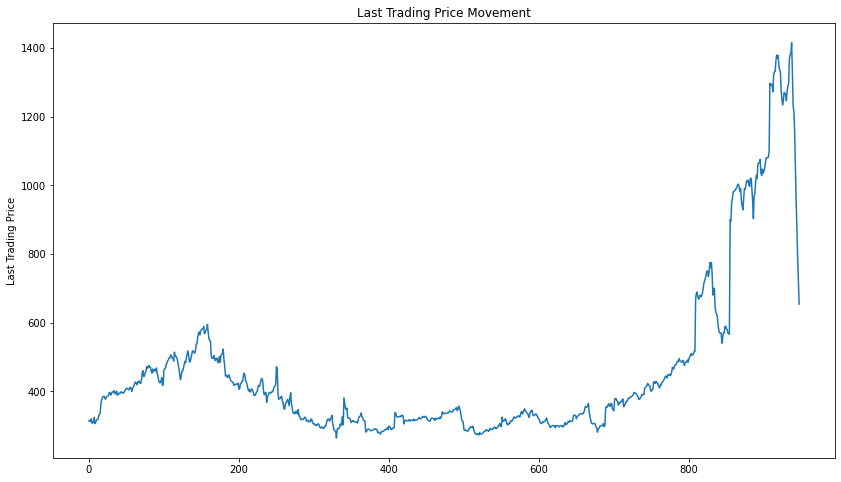

In [ ]:
df['Ltp'].plot(figsize=(14,8))
plt.ylabel("Last Trading Price")
plt.title("Last Trading Price Movement")
plt.show()

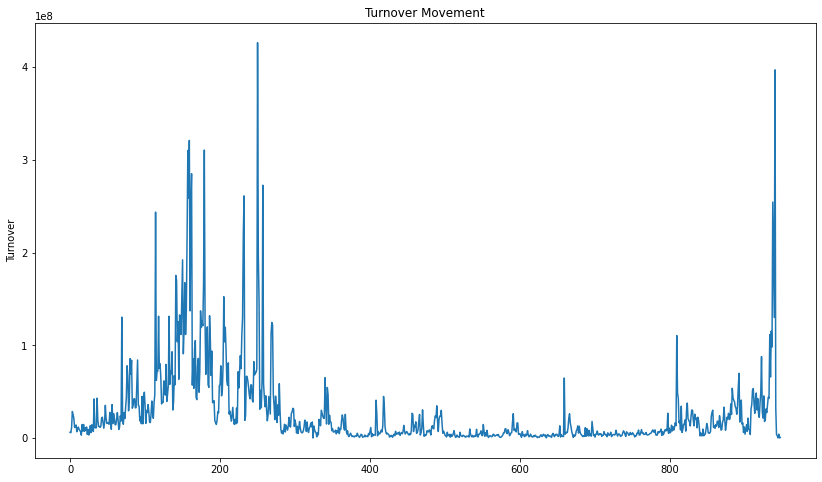

In [ ]:
turnover.plot(figsize=(14,8))
plt.ylabel("Turnover")
plt.title("Turnover Movement")
plt.show()

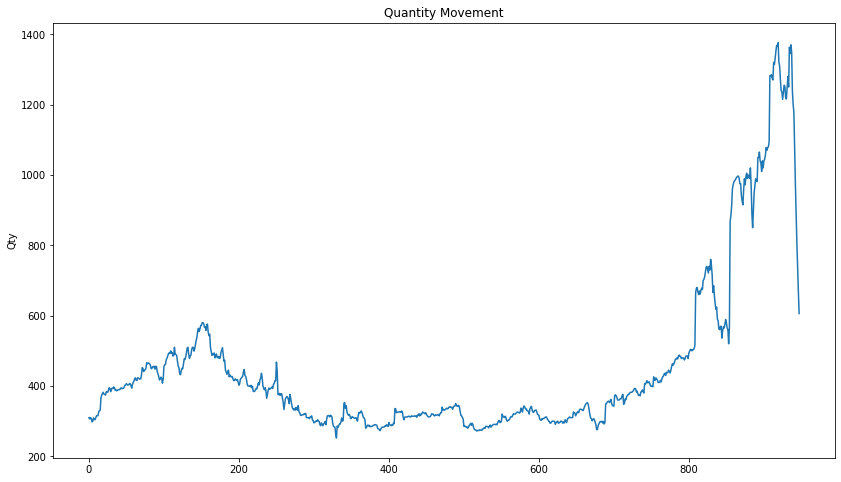

In [ ]:
qty.plot(figsize=(14,8))
plt.ylabel("Qty")
plt.title("Quantity Movement")
plt.show()

In [ ]:
df['economictext'].iloc[0]

"['EPF taking Oriental Cooperative Chairman Basnet owned Kohinoor Hill Housing to auction', 'Govt decides to develop Budhi Gandaki Hydro project in company model', 'Scarcity of chemical fertilizers due to negligence of contractor: Minister Yadav', 'Problems detected in transformers in Budhanilkantha', 'Gold price rises by Rs 100 per tola', 'Production of spring paddy up by 20 percent in Chitwan', 'Nepse increases by 41.39 points on Wednesday', 'DDC sells over 57,000 liters of yogurt on ‘Asar 15’', 'Appeal for formulation of laws relating to gold and silver business', 'Dollar hits all-time high', 'WB approves financing USD 275 million to Nepal to upgrade Butwal—Gorusinghe—Chanauta road', 'SC orders not to implement decision to reduce demarcation standards of Pokhara lakes']"

In [ ]:
df['politicaltext'].iloc[0]

"['Bamdev Gautam forms a new political party named ‘Nepal Communist Party Ekata Rastriya Abhiyan’', 'Unified Socialist Central Council meeting endorses 17-point proposal', 'Dahal is guilty in SPP: UML Chairman Oli', 'We have sown seeds of Maoism in UML, they will bear fruits after some time: Dahal', 'Accused of indecent behavior,&nbsp;Lumbini’s State Minister for Health Bimala Wali resigns', 'UML demands resignation of Gandaki CM', 'Replying to Dahal, UML’s Bhusal says, “The seeds of Maoism will grow no more.”', 'Govt cannot build Kerung-Kathmandu railway: Bishwa Prakash Sharma']"

In [ ]:
# Iterate over rows in economical news column

for index, row in df.iterrows(): 
    print (row["economictext"])

['EPF taking Oriental Cooperative Chairman Basnet owned Kohinoor Hill Housing to auction', 'Govt decides to develop Budhi Gandaki Hydro project in company model', 'Scarcity of chemical fertilizers due to negligence of contractor: Minister Yadav', 'Problems detected in transformers in Budhanilkantha', 'Gold price rises by Rs 100 per tola', 'Production of spring paddy up by 20 percent in Chitwan', 'Nepse increases by 41.39 points on Wednesday', 'DDC sells over 57,000 liters of yogurt on ‘Asar 15’', 'Appeal for formulation of laws relating to gold and silver business', 'Dollar hits all-time high', 'WB approves financing USD 275 million to Nepal to upgrade Butwal—Gorusinghe—Chanauta road', 'SC orders not to implement decision to reduce demarcation standards of Pokhara lakes']
['Stockbrokers permitted to operate their own TMS for online trading of shares', 'Newly-appointed Tourism Minister Shrestha calls for promoting tourism', 'Flights to Humla disrupted for three days', 'E. coli found in 

In [ ]:
# Iterate over rows in political news column

for index, row in df.iterrows(): 
    print (row["politicaltext"])

['Bamdev Gautam forms a new political party named ‘Nepal Communist Party Ekata Rastriya Abhiyan’', 'Unified Socialist Central Council meeting endorses 17-point proposal', 'Dahal is guilty in SPP: UML Chairman Oli', 'We have sown seeds of Maoism in UML, they will bear fruits after some time: Dahal', 'Accused of indecent behavior,&nbsp;Lumbini’s State Minister for Health Bimala Wali resigns', 'UML demands resignation of Gandaki CM', 'Replying to Dahal, UML’s Bhusal says, “The seeds of Maoism will grow no more.”', 'Govt cannot build Kerung-Kathmandu railway: Bishwa Prakash Sharma']
['Govt committed to development, good governance: Minister Karki', 'Central Council meeting of Unified Socialist being held', "Bamdev Gautam to launch 'CPN National Unity Campaign' Party today", 'Cabinet meeting called for 3 PM today', 'Speaker Agni Prasad Sapkota leaves for Azerbaijan', 'Seven vice-chairmen and 15 standing committee members in Bamdev Gautam-led party']
['Newly-appointed ministers to be sworn i

**Clean data in News Headling column**

In [ ]:
economic_clean_news = []

for i in range(0, len(df["economictext"])): 
    economic_clean_news.append(re.sub("\n", ' ', df["economictext"][i]))  # replace n\ with ' '
    economic_clean_news[i] = re.sub(r'[^a-zA-z0-9\s]','',economic_clean_news[i]) # removes all than alphabets and numbers

In [ ]:
# Show first row in economical news column

economic_clean_news[0]

'[EPF taking Oriental Cooperative Chairman Basnet owned Kohinoor Hill Housing to auction Govt decides to develop Budhi Gandaki Hydro project in company model Scarcity of chemical fertilizers due to negligence of contractor Minister Yadav Problems detected in transformers in Budhanilkantha Gold price rises by Rs 100 per tola Production of spring paddy up by 20 percent in Chitwan Nepse increases by 4139 points on Wednesday DDC sells over 57000 liters of yogurt on Asar 15 Appeal for formulation of laws relating to gold and silver business Dollar hits alltime high WB approves financing USD 275 million to Nepal to upgrade ButwalGorusingheChanauta road SC orders not to implement decision to reduce demarcation standards of Pokhara lakes]'

In [ ]:
political_clean_news = []

for i in range(0, len(df["politicaltext"])): 
    political_clean_news.append(re.sub("\n", ' ', df["politicaltext"][i]))  # replace n\ with ' '
    political_clean_news[i] = re.sub(r'[^a-zA-z0-9\s]','',political_clean_news[i]) # removes all than alphabets and numbers

In [ ]:
# Show first row in political news column

political_clean_news[0]

'[Bamdev Gautam forms a new political party named Nepal Communist Party Ekata Rastriya Abhiyan Unified Socialist Central Council meeting endorses 17point proposal Dahal is guilty in SPP UML Chairman Oli We have sown seeds of Maoism in UML they will bear fruits after some time Dahal Accused of indecent behaviornbspLumbinis State Minister for Health Bimala Wali resigns UML demands resignation of Gandaki CM Replying to Dahal UMLs Bhusal says The seeds of Maoism will grow no more Govt cannot build KerungKathmandu railway Bishwa Prakash Sharma]'

In [ ]:
df['economictext'] = economic_clean_news
df['politicaltext'] = political_clean_news

In [ ]:
df

Date    Open    High     Low    Ltp     Qty     Turnover  \
0    2022-06-29  318.90  318.90  310.00  315.0  310.00   6127716.20   
1    2022-06-28  312.00  316.50  306.00  313.0  306.00   5707986.70   
2    2022-06-27  322.00  325.00  310.00  312.0  310.00  11125995.50   
3    2022-06-26  312.90  320.00  308.00  320.0  308.00  28577745.10   
4    2022-06-24  305.00  310.00  298.20  307.0  298.20  25399389.80   
..          ...     ...     ...     ...    ...     ...          ...   
943  2016-07-17  869.00  955.00  886.00  955.0  886.00   2538590.00   
944  2016-07-14  790.00  869.00  805.00  869.0  805.00    151344.00   
945  2016-07-13  719.00  790.00  733.00  790.0  733.00   4231540.00   
946  2016-07-12  654.00  719.00  667.00  719.0  667.00     89570.00   
947  2016-07-11  595.00  654.00  606.00  654.0  606.00    685500.00   

                                          economictext  \
0    [EPF taking Oriental Cooperative Chairman Basn...   
1    [Stockbrokers permitted to operate their own T...   
2    [Nepal received FDI commitments of Rs 5156 bil...   
3    [17 cooperatives put in blacklist on charge of...   
4    [Agreement signed to study the feasibility of ...   
..                                                 ...   
943  [NEPSE records trade of shares worth 6 billion...   
944  [Govt laxity blamed for growing market ills Ne...   
945  [Capital threshold for industries to be raised...   
946  [Bajaj V15 hits Nepali roads PokharaDelhi bus ...   
947  [Central bank likely to tighten monetary polic...   

                                         politicaltext  \
0    [Bamdev Gautam forms a new political party nam...   
1    [Govt committed to development good governance...   
2    [Newlyappointed ministers to be sworn in today...   
3    [National Assembly meeting being held today CP...   
4    [National Assembly meeting at 1 PM today with ...   
..                                                 ...   
943  [NC summons CWC meeting for Tuesday Parties on...   
944  [House yet to endorse remaining bills of budge...   
945  [Land developers school responsible for wall c...   
946  [Flawed recommendation process of justices dra...   
947  [House hearings endorse Karki for chief justic...   

                                        economicaltext  
0    [EPF taking Oriental Cooperative Chairman Basn...  
1    [Stockbrokers permitted to operate their own T...  
2    [Nepal received FDI commitments of Rs 5156 bil...  
3    [17 cooperatives put in blacklist on charge of...  
4    [Agreement signed to study the feasibility of ...  
..                                                 ...  
943  [NEPSE records trade of shares worth 6 billion...  
944  [Govt laxity blamed for growing market ills Ne...  
945  [Capital threshold for industries to be raised...  
946  [Bajaj V15 hits Nepali roads PokharaDelhi bus ...  
947  [Central bank likely to tighten monetary polic...  

[948 rows x 10 columns]

**Sentiment Analysis** <br>
TextBlob will be used to get subjectivity and polarity scores for the cleaned and merged news data. Polarity is a float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgement whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1] where 0 is objective and 1 is subjective.

In [ ]:
# Create function to get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create function to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
# Create subjectivity and polarity in new column of economictext
df['economic-subjectivity'] = df['economictext'].apply(getSubjectivity)
df['economic-polarity'] = df['economictext'].apply(getPolarity)

In [ ]:
df

Date    Open    High     Low    Ltp     Qty     Turnover  \
0    2022-06-29  318.90  318.90  310.00  315.0  310.00   6127716.20   
1    2022-06-28  312.00  316.50  306.00  313.0  306.00   5707986.70   
2    2022-06-27  322.00  325.00  310.00  312.0  310.00  11125995.50   
3    2022-06-26  312.90  320.00  308.00  320.0  308.00  28577745.10   
4    2022-06-24  305.00  310.00  298.20  307.0  298.20  25399389.80   
..          ...     ...     ...     ...    ...     ...          ...   
943  2016-07-17  869.00  955.00  886.00  955.0  886.00   2538590.00   
944  2016-07-14  790.00  869.00  805.00  869.0  805.00    151344.00   
945  2016-07-13  719.00  790.00  733.00  790.0  733.00   4231540.00   
946  2016-07-12  654.00  719.00  667.00  719.0  667.00     89570.00   
947  2016-07-11  595.00  654.00  606.00  654.0  606.00    685500.00   

                                          economictext  \
0    [EPF taking Oriental Cooperative Chairman Basn...   
1    [Stockbrokers permitted to operate their own T...   
2    [Nepal received FDI commitments of Rs 5156 bil...   
3    [17 cooperatives put in blacklist on charge of...   
4    [Agreement signed to study the feasibility of ...   
..                                                 ...   
943  [NEPSE records trade of shares worth 6 billion...   
944  [Govt laxity blamed for growing market ills Ne...   
945  [Capital threshold for industries to be raised...   
946  [Bajaj V15 hits Nepali roads PokharaDelhi bus ...   
947  [Central bank likely to tighten monetary polic...   

                                         politicaltext  \
0    [Bamdev Gautam forms a new political party nam...   
1    [Govt committed to development good governance...   
2    [Newlyappointed ministers to be sworn in today...   
3    [National Assembly meeting being held today CP...   
4    [National Assembly meeting at 1 PM today with ...   
..                                                 ...   
943  [NC summons CWC meeting for Tuesday Parties on...   
944  [House yet to endorse remaining bills of budge...   
945  [Land developers school responsible for wall c...   
946  [Flawed recommendation process of justices dra...   
947  [House hearings endorse Karki for chief justic...   

                                        economicaltext  economic-subjectivity  \
0    [EPF taking Oriental Cooperative Chairman Basn...               0.457500   
1    [Stockbrokers permitted to operate their own T...               0.195556   
2    [Nepal received FDI commitments of Rs 5156 bil...               0.225000   
3    [17 cooperatives put in blacklist on charge of...               0.253704   
4    [Agreement signed to study the feasibility of ...               0.280303   
..                                                 ...                    ...   
943  [NEPSE records trade of shares worth 6 billion...               0.277273   
944  [Govt laxity blamed for growing market ills Ne...               0.303030   
945  [Capital threshold for industries to be raised...               0.293182   
946  [Bajaj V15 hits Nepali roads PokharaDelhi bus ...               0.315774   
947  [Central bank likely to tighten monetary polic...               0.563333   

     economic-polarity  
0             0.017500  
1             0.017778  
2            -0.012500  
3             0.038889  
4             0.042424  
..                 ...  
943           0.218182  
944           0.090909  
945           0.337121  
946           0.166369  
947           0.000000  

[948 rows x 12 columns]

In [ ]:
# Create subjectivity and polarity in new column of politicaltext
df['political-subjectivity'] = df['politicaltext'].apply(getSubjectivity)
df['political-polarity'] = df['politicaltext'].apply(getPolarity)

In [ ]:
df

Date    Open    High     Low    Ltp     Qty     Turnover  \
0    2022-06-29  318.90  318.90  310.00  315.0  310.00   6127716.20   
1    2022-06-28  312.00  316.50  306.00  313.0  306.00   5707986.70   
2    2022-06-27  322.00  325.00  310.00  312.0  310.00  11125995.50   
3    2022-06-26  312.90  320.00  308.00  320.0  308.00  28577745.10   
4    2022-06-24  305.00  310.00  298.20  307.0  298.20  25399389.80   
..          ...     ...     ...     ...    ...     ...          ...   
943  2016-07-17  869.00  955.00  886.00  955.0  886.00   2538590.00   
944  2016-07-14  790.00  869.00  805.00  869.0  805.00    151344.00   
945  2016-07-13  719.00  790.00  733.00  790.0  733.00   4231540.00   
946  2016-07-12  654.00  719.00  667.00  719.0  667.00     89570.00   
947  2016-07-11  595.00  654.00  606.00  654.0  606.00    685500.00   

                                          economictext  \
0    [EPF taking Oriental Cooperative Chairman Basn...   
1    [Stockbrokers permitted to operate their own T...   
2    [Nepal received FDI commitments of Rs 5156 bil...   
3    [17 cooperatives put in blacklist on charge of...   
4    [Agreement signed to study the feasibility of ...   
..                                                 ...   
943  [NEPSE records trade of shares worth 6 billion...   
944  [Govt laxity blamed for growing market ills Ne...   
945  [Capital threshold for industries to be raised...   
946  [Bajaj V15 hits Nepali roads PokharaDelhi bus ...   
947  [Central bank likely to tighten monetary polic...   

                                         politicaltext  \
0    [Bamdev Gautam forms a new political party nam...   
1    [Govt committed to development good governance...   
2    [Newlyappointed ministers to be sworn in today...   
3    [National Assembly meeting being held today CP...   
4    [National Assembly meeting at 1 PM today with ...   
..                                                 ...   
943  [NC summons CWC meeting for Tuesday Parties on...   
944  [House yet to endorse remaining bills of budge...   
945  [Land developers school responsible for wall c...   
946  [Flawed recommendation process of justices dra...   
947  [House hearings endorse Karki for chief justic...   

                                        economicaltext  economic-subjectivity  \
0    [EPF taking Oriental Cooperative Chairman Basn...               0.457500   
1    [Stockbrokers permitted to operate their own T...               0.195556   
2    [Nepal received FDI commitments of Rs 5156 bil...               0.225000   
3    [17 cooperatives put in blacklist on charge of...               0.253704   
4    [Agreement signed to study the feasibility of ...               0.280303   
..                                                 ...                    ...   
943  [NEPSE records trade of shares worth 6 billion...               0.277273   
944  [Govt laxity blamed for growing market ills Ne...               0.303030   
945  [Capital threshold for industries to be raised...               0.293182   
946  [Bajaj V15 hits Nepali roads PokharaDelhi bus ...               0.315774   
947  [Central bank likely to tighten monetary polic...               0.563333   

     economic-polarity  political-subjectivity  political-polarity  
0             0.017500                0.460909           -0.122727  
1             0.017778                0.425000            0.350000  
2            -0.012500                0.457792            0.169481  
3             0.038889                0.570909            0.241818  
4             0.042424                0.300000            0.128788  
..                 ...                     ...                 ...  
943           0.218182                0.461818            0.004545  
944           0.090909                0.326515           -0.087879  
945           0.337121                0.444805           -0.012987  
946           0.166369                0.343232           -0.007475  
947           0.000000          

**Summary Statistics and Visualize of Economic Text**

In [ ]:
#Statistics of Economic Text Subjectivity
df['economic-subjectivity'].describe()

count    948.000000
mean       0.320811
std        0.176394
min        0.000000
25%        0.200000
50%        0.315757
75%        0.439015
max        1.000000
Name: economic-subjectivity, dtype: float64

In [ ]:
df['economic-subjectivity'].value_counts()

0.000000    62
0.300000    16
0.100000    14
0.500000    14
0.400000    12
            ..
0.298829     1
0.256250     1
0.257860     1
0.252576     1
0.563333     1
Name: economic-subjectivity, Length: 607, dtype: int64

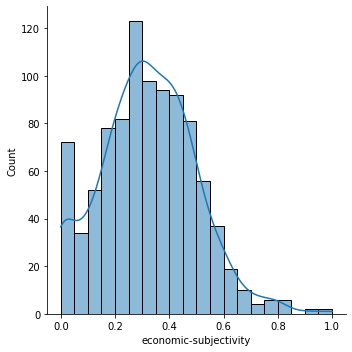

In [ ]:
sns.displot(df['economic-subjectivity'], bins=20, kde=True);

In [ ]:
#Statistics of Economic Text Polarity
df['economic-polarity'].describe()

count    948.000000
mean       0.059365
std        0.141399
min       -0.600000
25%       -0.006184
50%        0.050000
75%        0.136552
max        1.000000
Name: economic-polarity, dtype: float64

In [ ]:
#Statistics of Economic Text Polarity
df['economic-polarity'].value_counts()

 0.000000    104
 0.100000     18
 0.250000     17
 0.050000     16
 0.068182     10
            ... 
-0.015000      1
-0.150000      1
 0.304167      1
 0.006667      1
 0.166369      1
Name: economic-polarity, Length: 578, dtype: int64

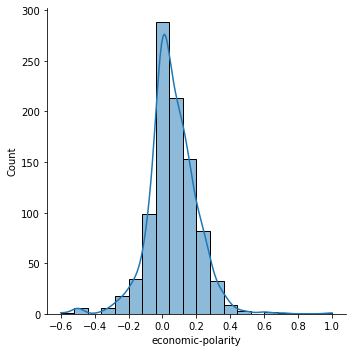

In [ ]:
sns.displot(df['economic-polarity'], bins=20, kde=True);

In [ ]:
#Statistics of Political Text Subjectivity
df['political-subjectivity'].describe()

count    948.000000
mean       0.307988
std        0.198543
min        0.000000
25%        0.175000
50%        0.300000
75%        0.428417
max        1.000000
Name: political-subjectivity, dtype: float64

In [ ]:
df['political-subjectivity'].value_counts()

0.000000    90
0.500000    40
0.100000    23
0.250000    18
0.454545    14
            ..
0.177778     1
0.120000     1
0.412037     1
0.344353     1
0.277381     1
Name: political-subjectivity, Length: 528, dtype: int64

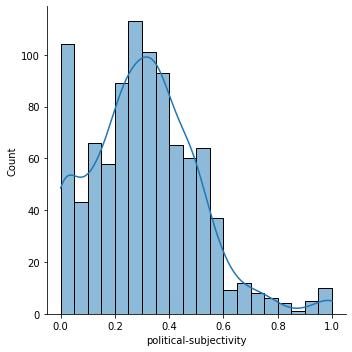

In [ ]:
sns.displot(df['political-subjectivity'], bins=20, kde=True);

In [ ]:
#Statistics of Political Text Polarity
df['political-polarity'].describe()

count    948.000000
mean       0.044399
std        0.137091
min       -0.650000
25%       -0.004505
50%        0.027435
75%        0.110278
max        0.600000
Name: political-polarity, dtype: float64

In [ ]:
df['political-polarity'].value_counts()

 0.000000    158
 0.100000     15
 0.136364     13
 0.050000     10
 0.068182      9
            ... 
-0.044444      1
 0.316667      1
 0.070707      1
 0.159642      1
-0.007475      1
Name: political-polarity, Length: 545, dtype: int64

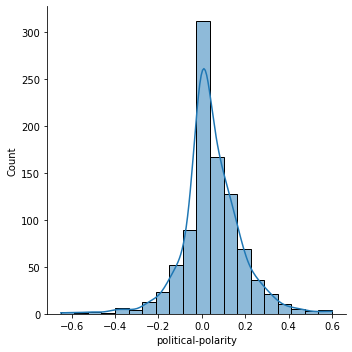

In [ ]:
sns.displot(df['political-polarity'], bins=20, kde=True);

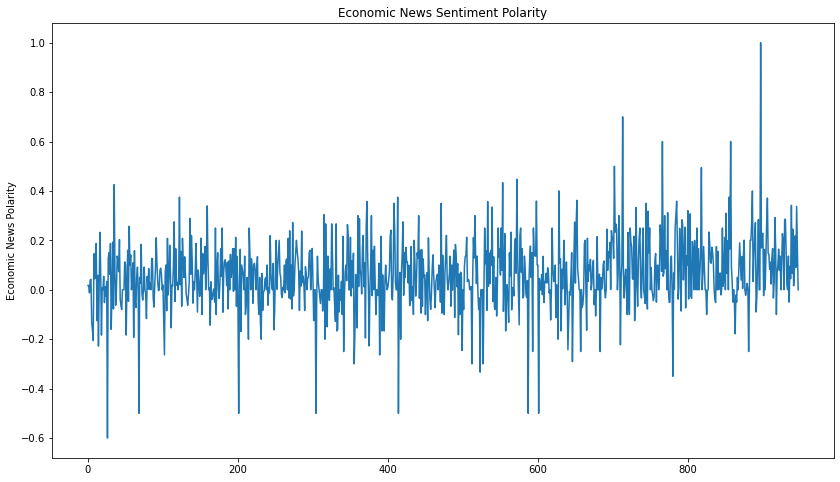

In [ ]:
df['economic-polarity'].plot(figsize=(14,8))
plt.ylabel("Economic News Polarity")
plt.title("Economic News Sentiment Polarity")
plt.show()

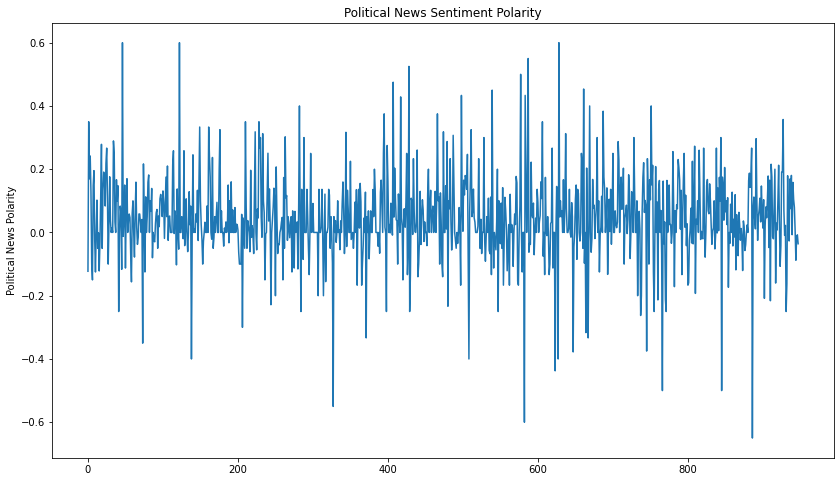

In [ ]:
df['political-polarity'].plot(figsize=(14,8))
plt.ylabel("Political News Polarity")
plt.title("Political News Sentiment Polarity")
plt.show()

In [ ]:
# "1" when  Ltp value rose or stayed as the same;
# "0" when Ltp value decreased.

df['Ltp Next Value'] = df['Ltp'].shift(-1)

In [ ]:
df

Date    Open    High     Low    Ltp     Qty     Turnover  \
0    2022-06-29  318.90  318.90  310.00  315.0  310.00   6127716.20   
1    2022-06-28  312.00  316.50  306.00  313.0  306.00   5707986.70   
2    2022-06-27  322.00  325.00  310.00  312.0  310.00  11125995.50   
3    2022-06-26  312.90  320.00  308.00  320.0  308.00  28577745.10   
4    2022-06-24  305.00  310.00  298.20  307.0  298.20  25399389.80   
..          ...     ...     ...     ...    ...     ...          ...   
943  2016-07-17  869.00  955.00  886.00  955.0  886.00   2538590.00   
944  2016-07-14  790.00  869.00  805.00  869.0  805.00    151344.00   
945  2016-07-13  719.00  790.00  733.00  790.0  733.00   4231540.00   
946  2016-07-12  654.00  719.00  667.00  719.0  667.00     89570.00   
947  2016-07-11  595.00  654.00  606.00  654.0  606.00    685500.00   

                                          economictext  \
0    [EPF taking Oriental Cooperative Chairman Basn...   
1    [Stockbrokers permitted to operate their own T...   
2    [Nepal received FDI commitments of Rs 5156 bil...   
3    [17 cooperatives put in blacklist on charge of...   
4    [Agreement signed to study the feasibility of ...   
..                                                 ...   
943  [NEPSE records trade of shares worth 6 billion...   
944  [Govt laxity blamed for growing market ills Ne...   
945  [Capital threshold for industries to be raised...   
946  [Bajaj V15 hits Nepali roads PokharaDelhi bus ...   
947  [Central bank likely to tighten monetary polic...   

                                         politicaltext  \
0    [Bamdev Gautam forms a new political party nam...   
1    [Govt committed to development good governance...   
2    [Newlyappointed ministers to be sworn in today...   
3    [National Assembly meeting being held today CP...   
4    [National Assembly meeting at 1 PM today with ...   
..                                                 ...   
943  [NC summons CWC meeting for Tuesday Parties on...   
944  [House yet to endorse remaining bills of budge...   
945  [Land developers school responsible for wall c...   
946  [Flawed recommendation process of justices dra...   
947  [House hearings endorse Karki for chief justic...   

                                        economicaltext  economic-subjectivity  \
0    [EPF taking Oriental Cooperative Chairman Basn...               0.457500   
1    [Stockbrokers permitted to operate their own T...               0.195556   
2    [Nepal received FDI commitments of Rs 5156 bil...               0.225000   
3    [17 cooperatives put in blacklist on charge of...               0.253704   
4    [Agreement signed to study the feasibility of ...               0.280303   
..                                                 ...                    ...   
943  [NEPSE records trade of shares worth 6 billion...               0.277273   
944  [Govt laxity blamed for growing market ills Ne...               0.303030   
945  [Capital threshold for industries to be raised...               0.293182   
946  [Bajaj V15 hits Nepali roads PokharaDelhi bus ...               0.315774   
947  [Central bank likely to tighten monetary polic...               0.563333   

     economic-polarity  political-subjectivity  political-polarity  \
0             0.017500                0.460909           -0.122727   
1             0.017778                0.425000            0.350000   
2            -0.012500                0.457792            0.169481   
3             0.038889                0.570909            0.241818   
4             0.042424                0.300000            0.128788   
..                 ...                     ...                 ...   
943           0.218182                0.461818            0.004545   
944           0.090909                0.326515           -0.087879   
945           0.337121                0.444805           -0.012987   
946           0.166369                0.343232           -0.007475   
947           0.00000

In [ ]:
df['Label'] = df.apply(lambda x: 1 if (x['Ltp Next Value']>= x['Ltp']) else 0, axis =1)

df[['Ltp', 'Ltp Next Value', 'Label']].head(5)

Ltp  Ltp Next Value  Label
0  315.0           313.0      0
1  313.0           312.0      0
2  312.0           320.0      1
3  320.0           307.0      0
4  307.0           310.0      1

In [ ]:
df

Date    Open    High     Low    Ltp     Qty     Turnover  \
0    2022-06-29  318.90  318.90  310.00  315.0  310.00   6127716.20   
1    2022-06-28  312.00  316.50  306.00  313.0  306.00   5707986.70   
2    2022-06-27  322.00  325.00  310.00  312.0  310.00  11125995.50   
3    2022-06-26  312.90  320.00  308.00  320.0  308.00  28577745.10   
4    2022-06-24  305.00  310.00  298.20  307.0  298.20  25399389.80   
..          ...     ...     ...     ...    ...     ...          ...   
943  2016-07-17  869.00  955.00  886.00  955.0  886.00   2538590.00   
944  2016-07-14  790.00  869.00  805.00  869.0  805.00    151344.00   
945  2016-07-13  719.00  790.00  733.00  790.0  733.00   4231540.00   
946  2016-07-12  654.00  719.00  667.00  719.0  667.00     89570.00   
947  2016-07-11  595.00  654.00  606.00  654.0  606.00    685500.00   

                                          economictext  \
0    [EPF taking Oriental Cooperative Chairman Basn...   
1    [Stockbrokers permitted to operate their own T...   
2    [Nepal received FDI commitments of Rs 5156 bil...   
3    [17 cooperatives put in blacklist on charge of...   
4    [Agreement signed to study the feasibility of ...   
..                                                 ...   
943  [NEPSE records trade of shares worth 6 billion...   
944  [Govt laxity blamed for growing market ills Ne...   
945  [Capital threshold for industries to be raised...   
946  [Bajaj V15 hits Nepali roads PokharaDelhi bus ...   
947  [Central bank likely to tighten monetary polic...   

                                         politicaltext  \
0    [Bamdev Gautam forms a new political party nam...   
1    [Govt committed to development good governance...   
2    [Newlyappointed ministers to be sworn in today...   
3    [National Assembly meeting being held today CP...   
4    [National Assembly meeting at 1 PM today with ...   
..                                                 ...   
943  [NC summons CWC meeting for Tuesday Parties on...   
944  [House yet to endorse remaining bills of budge...   
945  [Land developers school responsible for wall c...   
946  [Flawed recommendation process of justices dra...   
947  [House hearings endorse Karki for chief justic...   

                                        economicaltext  economic-subjectivity  \
0    [EPF taking Oriental Cooperative Chairman Basn...               0.457500   
1    [Stockbrokers permitted to operate their own T...               0.195556   
2    [Nepal received FDI commitments of Rs 5156 bil...               0.225000   
3    [17 cooperatives put in blacklist on charge of...               0.253704   
4    [Agreement signed to study the feasibility of ...               0.280303   
..                                                 ...                    ...   
943  [NEPSE records trade of shares worth 6 billion...               0.277273   
944  [Govt laxity blamed for growing market ills Ne...               0.303030   
945  [Capital threshold for industries to be raised...               0.293182   
946  [Bajaj V15 hits Nepali roads PokharaDelhi bus ...               0.315774   
947  [Central bank likely to tighten monetary polic...               0.563333   

     economic-polarity  political-subjectivity  political-polarity  \
0             0.017500                0.460909           -0.122727   
1             0.017778                0.425000            0.350000   
2            -0.012500                0.457792            0.169481   
3             0.038889                0.570909            0.241818   
4             0.042424                0.300000            0.128788   
..                 ...                     ...                 ...   
943           0.218182                0.461818            0.004545   
944           0.090909                0.326515           -0.087879   
945           0.337121                0.444805           -0.012987   
946           0.166369                0.343232           -0.007475   
947           0.00000

In [ ]:
# Show Ltp Next Value and Label with Date

df_label = df[['Ltp Next Value', 'Label']]
df_label

Ltp Next Value  Label
0             313.0      0
1             312.0      0
2             320.0      1
3             307.0      0
4             310.0      1
..              ...    ...
943           869.0      0
944           790.0      0
945           719.0      0
946           654.0      0
947             NaN      0

[948 rows x 2 columns]

In [ ]:
# Drop NaN row

df_label = df_label.dropna()
df_label

Ltp Next Value  Label
0             313.0      0
1             312.0      0
2             320.0      1
3             307.0      0
4             310.0      1
..              ...    ...
942           955.0      0
943           869.0      0
944           790.0      0
945           719.0      0
946           654.0      0

[947 rows x 2 columns]

In [ ]:
df

Date    Open    High     Low    Ltp     Qty     Turnover  \
0    2022-06-29  318.90  318.90  310.00  315.0  310.00   6127716.20   
1    2022-06-28  312.00  316.50  306.00  313.0  306.00   5707986.70   
2    2022-06-27  322.00  325.00  310.00  312.0  310.00  11125995.50   
3    2022-06-26  312.90  320.00  308.00  320.0  308.00  28577745.10   
4    2022-06-24  305.00  310.00  298.20  307.0  298.20  25399389.80   
..          ...     ...     ...     ...    ...     ...          ...   
943  2016-07-17  869.00  955.00  886.00  955.0  886.00   2538590.00   
944  2016-07-14  790.00  869.00  805.00  869.0  805.00    151344.00   
945  2016-07-13  719.00  790.00  733.00  790.0  733.00   4231540.00   
946  2016-07-12  654.00  719.00  667.00  719.0  667.00     89570.00   
947  2016-07-11  595.00  654.00  606.00  654.0  606.00    685500.00   

                                          economictext  \
0    [EPF taking Oriental Cooperative Chairman Basn...   
1    [Stockbrokers permitted to operate their own T...   
2    [Nepal received FDI commitments of Rs 5156 bil...   
3    [17 cooperatives put in blacklist on charge of...   
4    [Agreement signed to study the feasibility of ...   
..                                                 ...   
943  [NEPSE records trade of shares worth 6 billion...   
944  [Govt laxity blamed for growing market ills Ne...   
945  [Capital threshold for industries to be raised...   
946  [Bajaj V15 hits Nepali roads PokharaDelhi bus ...   
947  [Central bank likely to tighten monetary polic...   

                                         politicaltext  \
0    [Bamdev Gautam forms a new political party nam...   
1    [Govt committed to development good governance...   
2    [Newlyappointed ministers to be sworn in today...   
3    [National Assembly meeting being held today CP...   
4    [National Assembly meeting at 1 PM today with ...   
..                                                 ...   
943  [NC summons CWC meeting for Tuesday Parties on...   
944  [House yet to endorse remaining bills of budge...   
945  [Land developers school responsible for wall c...   
946  [Flawed recommendation process of justices dra...   
947  [House hearings endorse Karki for chief justic...   

                                        economicaltext  economic-subjectivity  \
0    [EPF taking Oriental Cooperative Chairman Basn...               0.457500   
1    [Stockbrokers permitted to operate their own T...               0.195556   
2    [Nepal received FDI commitments of Rs 5156 bil...               0.225000   
3    [17 cooperatives put in blacklist on charge of...               0.253704   
4    [Agreement signed to study the feasibility of ...               0.280303   
..                                                 ...                    ...   
943  [NEPSE records trade of shares worth 6 billion...               0.277273   
944  [Govt laxity blamed for growing market ills Ne...               0.303030   
945  [Capital threshold for industries to be raised...               0.293182   
946  [Bajaj V15 hits Nepali roads PokharaDelhi bus ...               0.315774   
947  [Central bank likely to tighten monetary polic...               0.563333   

     economic-polarity  political-subjectivity  political-polarity  \
0             0.017500                0.460909           -0.122727   
1             0.017778                0.425000            0.350000   
2            -0.012500                0.457792            0.169481   
3             0.038889                0.570909            0.241818   
4             0.042424                0.300000            0.128788   
..                 ...                     ...                 ...   
943           0.218182                0.461818            0.004545   
944           0.090909                0.326515           -0.087879   
945           0.337121                0.444805           -0.012987   
946           0.166369                0.343232           -0.007475   
947           0.00000

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Ltp', 'Qty', 'Turnover', 'economictext',
       'politicaltext', 'economicaltext', 'economic-subjectivity',
       'economic-polarity', 'political-subjectivity', 'political-polarity',
       'Ltp Next Value', 'Label'],
      dtype='object')

In [ ]:
# Collapse data set to keep relevant stock price and sentiment score columns only

keep_columns = ['Date', 'Open', 'High', 'Low', 'Ltp', 'Qty', 'Turnover','economic-subjectivity',
                'economic-polarity', 'political-subjectivity', 'political-polarity', 'Label']
df =  df[keep_columns]
df

Date    Open    High     Low    Ltp     Qty     Turnover  \
0    2022-06-29  318.90  318.90  310.00  315.0  310.00   6127716.20   
1    2022-06-28  312.00  316.50  306.00  313.0  306.00   5707986.70   
2    2022-06-27  322.00  325.00  310.00  312.0  310.00  11125995.50   
3    2022-06-26  312.90  320.00  308.00  320.0  308.00  28577745.10   
4    2022-06-24  305.00  310.00  298.20  307.0  298.20  25399389.80   
..          ...     ...     ...     ...    ...     ...          ...   
943  2016-07-17  869.00  955.00  886.00  955.0  886.00   2538590.00   
944  2016-07-14  790.00  869.00  805.00  869.0  805.00    151344.00   
945  2016-07-13  719.00  790.00  733.00  790.0  733.00   4231540.00   
946  2016-07-12  654.00  719.00  667.00  719.0  667.00     89570.00   
947  2016-07-11  595.00  654.00  606.00  654.0  606.00    685500.00   

     economic-subjectivity  economic-polarity  political-subjectivity  \
0                 0.457500           0.017500                0.460909   
1                 0.195556           0.017778                0.425000   
2                 0.225000          -0.012500                0.457792   
3                 0.253704           0.038889                0.570909   
4                 0.280303           0.042424                0.300000   
..                     ...                ...                     ...   
943               0.277273           0.218182                0.461818   
944               0.303030           0.090909                0.326515   
945               0.293182           0.337121                0.444805   
946               0.315774           0.166369                0.343232   
947               0.563333           0.000000                0.277381   

     political-polarity  Label  
0             -0.122727      0  
1              0.350000      0  
2              0.169481      1  
3              0.241818      0  
4              0.128788      1  
..                  ...    ...  
943            0.004545      0  
944           -0.087879      0  
945           -0.012987      0  
946           -0.007475      0  
947           -0.035714      0  

[948 rows x 12 columns]

In [ ]:
df.to_csv("updated-dataset-with-subjectivity-polarity-label.csv")

In [ ]:
df.set_index('Date',inplace=True)

In [ ]:
df.shape

(948, 11)